# Import Package

In [1]:
import numpy as np
from numpy import nan
from numpy import isnan
from numpy import split
from numpy import array
from numpy import concatenate

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

import matplotlib.pyplot as plt
from matplotlib import pyplot
from pylab import *
plt.rcParams['font.sans-serif'] = ['SimHei']

import math
from math import sqrt

import re
import tqdm
import random
import os
import itertools
import argparse
import joblib
import xlrd
from collections import defaultdict
import copy

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn import datasets

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

import datetime
import calendar
import time
from datetime import date,datetime

import xgboost as xgb
from xgboost import plot_importance, plot_tree

import seaborn as sns
import stats as sts#df2

from scipy import stats
from scipy.special import softmax

from keras.models import load_model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import torch
import torch.nn as nn


Bad key "nbagg.transparent" on line 426 in
D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_path" on line 509 in
D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_args" on line 512 in
D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution
In D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.

# Load data

In [2]:
abc=30#表示30min为一段
gdf0=pd.read_csv(r'F:\博士科研资料\博士开题及其素材\加油站数据\export11.csv',encoding='gb18030')
gdf0['Time1'] = pd.to_datetime(gdf0['Time'],errors='coerce') 
gdf0['Hour'] = gdf0['Time1'].dt.hour.fillna(0).astype("int")    #转化提取小时
gdf0['Minute'] = gdf0['Time1'].dt.minute.fillna(0).astype("int") #转化提取分钟
gdf0['Hour']=gdf0['Hour'].astype(str)
gdf0['Date'] = pd.to_datetime(gdf0['Date'])
gdf0['T'] = gdf0['Hour'].apply(lambda x : int(x))+gdf0['Minute'].apply (lambda x :round(x/60,2))
gdf0['volume'] = gdf0['volume']
gdf0['MinuteLabel']=gdf0['Hour'].apply(lambda x : math.floor((int(x)*60)/abc))+gdf0['Minute'].apply (lambda x :math.floor(x/abc))#表示该时刻点属于哪个区间,因为有0，所以向下取整数
day_name00=gdf0.groupby(["NAME"])         #
for name,group in day_name00:#group是星期数一样的类目
    if name=='92H':
        df0=group
df0=df0[df0['Date'] >= "2020-06-01"] 
df0= df0[~( df0['Date'].isin(["2020-06-11","2020-08-11", "2020-08-25", "2020-09-11"]) )]###删除这些行，因为很多0

# Data preprogressing

In [3]:
DFStockOut=df0.iloc[:,[6,7,11,3,10,12]]
c=3
a=DFStockOut.shape[1]
ReStartStock=13790#10000#该变量表示补货到达后的初始库存
DFStockOut['OurLeaveStock']=DFStockOut['Date'].apply(lambda x : ReStartStock)#6
DFStockOut['OurBuHuoStart']=DFStockOut['Date'].apply(lambda x : 0)#补货触发时刻7
b=a+1
DFStockOut['Date']=pd.to_datetime(DFStockOut['Date'])
StockOutTime=[]
DHCS1=0#表示订货次数
DFStockOut['AllMinutes']=DFStockOut['MinuteLabel'].apply(lambda x: time.strftime("%H:%M:%S", time.gmtime( float((x+1)*abc*60))))
for i in range(DFStockOut.shape[0]):
    if DFStockOut.iloc[i,-1]=="00:00:00":
        DFStockOut.iloc[i,-1]="23:59:00"  ###1月20日0:00:00表示的是1月20日24:00:00,而无法取24h，所以设为23.59    
DFStockOut['timestamp']=DFStockOut['Date'].astype('str')+ ' ' + DFStockOut['AllMinutes'].astype('str')
DFStockOut['timestamp'] = pd.to_datetime(DFStockOut['timestamp'])#pd.to_datetime它无法转换
print(DFStockOut.shape)#(321121, 9)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

(207441, 10)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [4]:
df2 = df0.groupby(["Date","MinuteLabel"])['volume'].sum().reset_index(name ='UnitSales')#只留下小时销量数据
df2['Date'] = pd.to_datetime(df2['Date']) 
df2['Month_id']=df2['Date'].dt.month
df2['weekday'] = df2['Date'].apply(lambda time: time.dayofweek)
df2['MinuteLabel']=df2['MinuteLabel'].astype(str)
df2['weekday_hour'] = df2.weekday.astype(str) +' '+ df2.MinuteLabel.astype(str)
df2['m_weekday'] = df2.weekday_hour.replace(df2[:].groupby('weekday_hour')['UnitSales'].mean().to_dict())
init1 = df2.m_weekday[:].apply(np.log).values#
df2['PreproccessUnitSales'] =df2.UnitSales[:].apply(np.log).values - init1#数取对数-均值的对数
dfghu=df2.sort_values(by=['UnitSales'],ascending=[True]) 
df2['UnitSales']=df2['UnitSales'].apply(lambda x: (x-dfghu.iloc[0,2])/(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2]))
df2['MinuteLabel']=df2['MinuteLabel'].astype(int)

In [5]:
idx=list(range(0,int(24*60/abc)))                                                         
i=0
colorSet=['cyan','g','palegreen','c','lime','tomato','r']
DayName=['Mony','Tues','Wednes', 'Thurs', 'Fri', 'Satur', 'Sun']
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_name=df2.groupby(["weekday"])         #
for name,group in day_name:#group是星期数一样的类目
    group1=group.groupby(["Date"])
    j=0
    for name,group2 in group1:#group2是星期数、日期数一样的类目，即一天  
         group2=group2.sort_values(by=['MinuteLabel'],ascending=True,na_position='first')  # 按时间排序                  
         group2 = group2.set_index('MinuteLabel')#group2设置索引为Hour         
         group2 = group2.reindex(idx, fill_value=0)
         group2['MinuteLabel'] = group2.index          
         group2['Date']=name
         group2['weekday'] = group2['Date'].apply(lambda time: time.dayofweek)
         group2['day_name']=group2['weekday'].apply (lambda x : days[x])
         if i==0 and j==0:
            df3=group2
         else:      
            df3=pd.concat([df3,group2], axis=0, ignore_index=True)#axis:合并方式，默认0表示按列合并，1表示按行合并;ignore_index:是否忽略索引                   
         j=j+1
    i=i+1
df3=df3.sort_values(by=['Date','MinuteLabel'],ascending=[True,True]) #df3是没有的，用0不足的dataframe
df3['HourLabel']=df3['MinuteLabel'].apply(lambda x: math.floor(x*abc/60))

In [6]:
df5=df3.iloc[:,:]
df3['HourLabel']=df3['HourLabel'].astype(int)
df5['weekday'] = df5.Date.dt.weekday
df5['weekday_hour'] = df5.weekday.astype(str) +' '+ df5.HourLabel.astype(str)
df5['m_weekday'] = df5.weekday_hour.replace(df5[:].groupby('weekday_hour')['UnitSales'].mean().to_dict())
df5.to_csv('hour_Demand_consumption.csv')
df5['AllMinutes']=df5['MinuteLabel'].apply(lambda x: time.strftime("%H:%M:%S", time.gmtime( float((x+1)*abc*60))))
for i in range(df5.shape[0]):
    if df5.loc[i,'AllMinutes']=="00:00:00": 
        df5.loc[i,'AllMinutes']="23:59:00"  ###1月20日0:00:00表示的是1月20日24:00:00,而无法取24h，所以设为23.59

df = pd.DataFrame(columns=['timestamp', 'value'])###初始化
df['timestamp']=df5['Date'].astype('str')+ ' ' + df5['AllMinutes'].astype('str')
df['timestamp'] = pd.to_datetime(df['timestamp'])#为什么成了选取偶数
#df['value']=df5['UnitSales']+100#将小时销量转换为value值，且为了0不可用，所有的值增加100.
df['value']=df5['UnitSales']
df=df.sort_values(by=['timestamp'],ascending=[True]) 
df['Date']=df['timestamp'].apply(lambda x: x.strftime("%Y-%m-%d"))#提取时间戳中的日期
df['MinuteLabel']=df5['MinuteLabel']
df['yr'] = df.timestamp.dt.year
df['mt'] = df.timestamp.dt.month
df['d'] = df.timestamp.dt.day
df['H'] = df5['HourLabel']
df['Mi'] = df5['MinuteLabel']#表示第几个单位时间
df['weekday'] = df.timestamp.dt.weekday
df['weekday_hour'] = df.weekday.astype(str) +' '+ df.Mi.astype(str)
df['m_weekday'] = df.weekday_hour.replace(df[:].groupby('weekday_hour')['value'].mean().to_dict())
df=df.sort_values(by=['timestamp','Mi'],ascending=[True,True]) #df3是没有的，用0不足的dataframe

# Parameter sensitivity experiment

## Define functions

In [18]:
###00数据裂变划分,用于自定义函数DataPreprogress(df)
def to_supervised2(data, n_input, n_out):#数据裂变划分
    #将所有数据转换为输入(X[..,len(x_input),1])、y[..,len(data[in_end:out_end, 0])]
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):# 逐步遍历整个历史数据
        in_end = in_start + n_input## 定义输入序列的结束点
        out_end = in_end + n_out
        if out_end < (len(data)+1):# 确保有足够的数据
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        in_start += 1    # 依次推进时间
    return array(X), array(y)
###01前期数据准备
def DataPreprogress(df):
    init1 = df.m_weekday[:].apply(lambda x: 0).values#均值取对数
    label1 = df.value[:].values - init1#没必要取对数吧
    Date1=df.timestamp[:]#获得对应时间戳
    label1=np.array(label1).reshape(len(label1),1)#1维变2维
    init1=np.array(init1).reshape(len(init1),1)#1维变2维
    Date1=np.array(Date1).reshape(len(Date1),1)
    ##数据列变为x、y，拆分##训练、测试数据转换形式
    Xx, Yy = to_supervised2(label1, n_input, n_out)#准备数据#00
    Date1Xx, Date1Yy = to_supervised2(Date1, n_input, n_out)#准备数据#00
    initXx, initYy = to_supervised2(init1, n_input, n_out)#准备数据#00
    return init1,label1,Date1,Xx, Yy,Date1Xx, Date1Yy,initXx,initYy
###02将数据分为测试组和训练组
def split_dataset2(x,y):# split a univariate dataset into train/test sets
    train_x, test_x = x[:SplitNum], x[SplitNum:]
    train_y, test_y = y[:SplitNum], y[SplitNum:]
    return train_x, test_x,train_y, test_y

In [19]:
###02 基于01模型进行预测
def forecast2(model, test_x,inittest_y):#基于model，得到预测值y
    input_x = array(test_x)
    input_x = input_x.reshape((1, len(input_x), 1))# reshape into [1, n_input, 1]
    pred_00=[]
    predd = model.predict(input_x, verbose=0)    
    predd = predd[0]# we only want the vector forecast
    predd = predd.reshape((len(predd), 1))
    pred_00.append(predd)
    pred_00 = np.asarray(pred_00)[:,:,0] 
    pred_00_m = (pred_00[0]+ inittest_y[:])*(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2])+dfghu.iloc[0,2]
    return pred_00_m

###03,测试部分,基于预测模型得到预测值
def PredictValueTest(model,test_x,inittest_y,q):
    ii=0#表示model1_list
    predictionspredList=[]#得到多个分位数预测模型、不同重复次数下的预测值集合（predictionspredList）
    for ij in range(len(test_x)):
        pred = forecast2(model,test_x[ij,:], inittest_y[ij,:])#得到预测值
        predictionspredList.append(pred)
    predictionspredList = array(predictionspredList)#list转换为数组
    return  predictionspredList

In [20]:
def q_loss(q,y,f):### 定义分位数损失函数
    e = (y-f)#真实值-预测值
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)#q表示分位数
def q_loss0(qq,test_y1,predictionspred):### 定义分位数损失函数
    SumSW=0
    for i in range(len(test_y1)):
        for j in range(len(test_y1[i])):
            e=predictionspred[i][j]-test_y1[i][j]
            if e>=0:
               qLoss=(1-qq)*e
            else:
               qLoss=qq*(-e)
            SumSW+=qLoss
    return round(SumSW, 2)
#03评估预测误差
def evaluate_forecasts1(actual, predicted,qq):#返回预测值的总RMSE以及每天RMSE的列表
    scores = list() 
    for i in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, i], predicted[:, i])#计算MSE
        rmse = sqrt(mse)#计算RMSE
        scores.append(rmse)#计算每个预测值的RMSE,存放在列表#这个现在来看没有多大意义，因为不是同一个时刻,表示向前1步、2步、几步的预测效果
    s = 0
    sMAE = 0
    sMAPE = 0
    RMSE1=list()
    for row in range(actual.shape[0]):
        ss=0
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
            ss+= (actual[row, col] - predicted[row, col]) ** 2
            sMAE+= np.abs(actual[row, col] - predicted[row, col])
            sMAPE+= np.abs((actual[row, col] - predicted[row, col])/actual[row, col])
        RMSE1.append(sqrt(ss/actual.shape[1]))##每一组的RMSE
    Allq_loss=q_loss0(qq,actual,predicted)
    AllNum=actual.shape[0] * actual.shape[1]
    AllRMSE = sqrt(s / AllNum)#计算所有值的RMSE
    AllMSE = s / AllNum#计算所有值的RMSE
    AllMAE =sMAE/AllNum
    AllMAPE =sMAPE/AllNum  
    name='[Num]/RMSE/MSE/MAE/MAPE/q_loss'
    SingPredictscores = list() 
    SingPredictscores.append(AllRMSE)
    SingPredictscores.append(AllMSE)
    SingPredictscores.append(AllMAE)
    SingPredictscores.append(AllMAPE)
    SingPredictscores.append(Allq_loss)
    SingPredictscores = ', '.join(['%.1f' % s for s in SingPredictscores])
    return AllRMSE,scores,AllMSE,AllMAE,AllMAPE,AllNum,Allq_loss
###06
def summarize_scores(name, score, scores):#总结分数
    s_scores = ', '.join(['%.1f' % s for s in scores])

###04 测试部分，预测结果的传统评价
def  ValueTest(test_y,inittest_y,predictionspredI,qq):
    ###得到测试y值的原始值
    test_y1=test_y.copy()## 对原始的array1的复制
    for i in range(test_y.shape[0]):
        test_y1[i, :]=(test_y[i, :] + inittest_y[i,:])*(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2])+dfghu.iloc[0,2]#不用求exp啦
    PredictScresSet=[]
    AllRMSE,scores,AllMSE,AllMAE,AllMAPE,AllNum,Allq_loss=evaluate_forecasts1(test_y1[:, :], predictionspredI,qq)
    PredictScresSet.append(AllRMSE)
    PredictScresSet.append(AllMSE)
    PredictScresSet.append(AllMAE)
    PredictScresSet.append(AllMAPE)
    PredictScresSet.append(AllNum)
    PredictScresSet.append(Allq_loss)
    days = range(n_out)
    return PredictScresSet

In [21]:
def run(trial):
    qq=0.999
    space = {        
        'optimizer':  trial.suggest_categorical('optimizer', [optimizers.Adam]),
        'units': trial.suggest_int('units', 5, 500, 5),
        'epochs': trial.suggest_int('epochs', 10, 100, 10),
        'batch_size': trial.suggest_categorical('batch_size', [8,16, 32, 64, 128, 256,512]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 8e-1)
    }
    tf.random.set_seed(33)
    tf.random.set_seed(33)
    os.environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)
    session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)    
    def q_loss(q,y,f):### 定义分位数损失函数
        e = (y-f)#真实值-预测值
        return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)#q表示分位数
    losses = [lambda y,f: q_loss(qq,y,f)]#3个分位数的损失函数       
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    model = Sequential()# define model
    model.add(LSTM(units=space['units'], activation='relu', input_shape=(n_timesteps, n_features)))
    ###200表示隐藏状态维度
    model.add(Dense(n_outputs))
    model.compile(optimizer=space['optimizer'](learning_rate=space['learning_rate']), loss=losses)  # 平均误差损失
    history = model.fit(train_x, train_y, epochs=space['epochs'], batch_size=space['batch_size'], verbose=0, shuffle=False)   
    predictionspredList=PredictValueTest(model,test_x,inittest_y,qq)
    PointredictScresSet0=ValueTest(test_y,inittest_y,predictionspredList,qq)
    model.summary()
    p1 = pyplot.plot(history.history['loss'], color='blue', label='train')#画出学习过程
    ####分位数返回的是分位数值
    print('PointredictScresSet0[-1]',PointredictScresSet0[-1])
    return PointredictScresSet0[-1]

## Data split

In [22]:
###定义参数取值
n_input =4
n_out = 4
n_vars = 4
global SplitNum
SplitNum=int((df.shape[0]/int(24*60/abc))*0.7)*int(24*60/abc)-n_input-48*2##天数的百分之0.7,再乘以48
###00前期数据准备
init1,label1,Date1,Xx, Yy,Date1Xx, Date1Yy,initXx, initYy=DataPreprogress(df)
##数据拆分
train_x, test_x,train_y, test_y = split_dataset2(Xx, Yy)#01
print('len(train_x), len(test_x),len(train_y), len(test_y)',len(train_x), len(test_x),len(train_y), len(test_y))
print(len(Xx), len(Yy))
inittrain_x, inittest_x,inittrain_y, inittest_y = split_dataset2(initXx, initYy)#01
Datetrain_x, Datetest_x,Datetrain_y, Datetest_y = split_dataset2(Date1Xx, Date1Yy)#01

len(train_x), len(test_x),len(train_y), len(test_y) 6956 3117 6956 3117
10073 10073


## Concrete hyperparameters based on optuna

In [24]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

[I 2022-11-09 09:33:13,990] A new study created in memory with name: no-name-56828130-8b03-4f0a-9001-4addd8f0fce0
D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 09:39:10,679] Trial 0 finished with value: 34790.86 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 335, 'epochs': 60, 'batch_size': 8, 'learning_rate': 0.17334973320020208}. Best is trial 0 with value: 34790.86.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 335)               451580    
_________________________________________________________________
dense (Dense)                (None, 4)                 1344      
Total params: 452,924
Trainable params: 452,924
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 34790.86


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 09:41:47,258] Trial 1 finished with value: 14692.84 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 370, 'epochs': 80, 'batch_size': 64, 'learning_rate': 0.007489876475946666}. Best is trial 1 with value: 14692.84.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 370)               550560    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1484      
Total params: 552,044
Trainable params: 552,044
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14692.84


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 09:43:39,247] Trial 2 finished with value: 17243.68 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 350, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.012424899041321777}. Best is trial 1 with value: 14692.84.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 350)               492800    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1404      
Total params: 494,204
Trainable params: 494,204
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 17243.68


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 09:45:00,344] Trial 3 finished with value: 15203.82 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 260, 'epochs': 60, 'batch_size': 128, 'learning_rate': 0.02250083538590025}. Best is trial 1 with value: 14692.84.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 260)               272480    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1044      
Total params: 273,524
Trainable params: 273,524
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15203.82


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 09:50:45,584] Trial 4 finished with value: 41131.56 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 480, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.12836073543597176}. Best is trial 1 with value: 14692.84.


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 480)               925440    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 1924      
Total params: 927,364
Trainable params: 927,364
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 41131.56


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 09:52:22,330] Trial 5 finished with value: 15627.04 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 280, 'epochs': 60, 'batch_size': 512, 'learning_rate': 0.0027962240616553505}. Best is trial 1 with value: 14692.84.


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 280)               315840    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1124      
Total params: 316,964
Trainable params: 316,964
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15627.04


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 09:53:45,855] Trial 6 finished with value: 15391.47 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 295, 'epochs': 30, 'batch_size': 256, 'learning_rate': 0.12009640595847725}. Best is trial 1 with value: 14692.84.


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 295)               350460    
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 1184      
Total params: 351,644
Trainable params: 351,644
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15391.47


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:04:03,596] Trial 7 finished with value: 15510.35 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 500, 'epochs': 50, 'batch_size': 8, 'learning_rate': 0.00714871978927898}. Best is trial 1 with value: 14692.84.


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 500)               1004000   
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 2004      
Total params: 1,006,004
Trainable params: 1,006,004
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15510.35


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:05:03,794] Trial 8 finished with value: 16908.89 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 250, 'epochs': 20, 'batch_size': 256, 'learning_rate': 0.004261954144946295}. Best is trial 1 with value: 14692.84.


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 250)               252000    
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 1004      
Total params: 253,004
Trainable params: 253,004
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 16908.89


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:06:41,476] Trial 9 finished with value: 17504.83 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 450, 'epochs': 30, 'batch_size': 256, 'learning_rate': 0.021858770292729715}. Best is trial 1 with value: 14692.84.


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 450)               813600    
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 1804      
Total params: 815,404
Trainable params: 815,404
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 17504.83


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:08:08,246] Trial 10 finished with value: 14914.69 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 80, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.001743784520646454}. Best is trial 1 with value: 14692.84.


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 80)                26240     
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 324       
Total params: 26,564
Trainable params: 26,564
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14914.69


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:09:19,517] Trial 11 finished with value: 15277.84 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 40, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0013143126334182434}. Best is trial 1 with value: 14692.84.


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 40)                6720      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 164       
Total params: 6,884
Trainable params: 6,884
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15277.84


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:10:39,283] Trial 12 finished with value: 14272.51 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 80, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0011199070633804355}. Best is trial 12 with value: 14272.51.


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 80)                26240     
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 324       
Total params: 26,564
Trainable params: 26,564
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14272.51


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:11:54,588] Trial 13 finished with value: 148820.28 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 135, 'epochs': 80, 'batch_size': 64, 'learning_rate': 0.6675271788839503}. Best is trial 12 with value: 14272.51.


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 135)               73980     
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 544       
Total params: 74,524
Trainable params: 74,524
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 148820.28


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:13:11,937] Trial 14 finished with value: 14680.83 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 155, 'epochs': 80, 'batch_size': 64, 'learning_rate': 0.0010455781112441737}. Best is trial 12 with value: 14272.51.


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 155)               97340     
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 624       
Total params: 97,964
Trainable params: 97,964
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14680.83


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:14:49,837] Trial 15 finished with value: 14729.48 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 175, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.0011036589217986311}. Best is trial 12 with value: 14272.51.


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 175)               123900    
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 704       
Total params: 124,604
Trainable params: 124,604
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14729.48


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:15:37,913] Trial 16 finished with value: 16331.13 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 5, 'epochs': 90, 'batch_size': 512, 'learning_rate': 0.0030478832996571202}. Best is trial 12 with value: 14272.51.


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 5)                 140       
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 24        
Total params: 164
Trainable params: 164
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 16331.13


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:17:45,779] Trial 17 finished with value: 29115.71 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 155, 'epochs': 90, 'batch_size': 16, 'learning_rate': 0.05415386455101785}. Best is trial 12 with value: 14272.51.


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 155)               97340     
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 624       
Total params: 97,964
Trainable params: 97,964
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 29115.71


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:18:42,970] Trial 18 finished with value: 15643.7 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 100, 'epochs': 70, 'batch_size': 128, 'learning_rate': 0.002239034440812714}. Best is trial 12 with value: 14272.51.


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 404       
Total params: 41,204
Trainable params: 41,204
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15643.7


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:20:58,203] Trial 19 finished with value: 14557.92 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 220, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0058855809201634485}. Best is trial 12 with value: 14272.51.


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 220)               195360    
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 884       
Total params: 196,244
Trainable params: 196,244
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14557.92


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:23:22,215] Trial 20 finished with value: 14394.57 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 240, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.005750993859132203}. Best is trial 12 with value: 14272.51.


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 240)               232320    
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 964       
Total params: 233,284
Trainable params: 233,284
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14394.57


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:25:45,521] Trial 21 finished with value: 15977.44 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 215, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.007598755493735847}. Best is trial 12 with value: 14272.51.


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 215)               186620    
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 864       
Total params: 187,484
Trainable params: 187,484
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15977.44


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:27:50,437] Trial 22 finished with value: 15762.36 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 205, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.005197121972462611}. Best is trial 12 with value: 14272.51.


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 205)               169740    
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 824       
Total params: 170,564
Trainable params: 170,564
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15762.36


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:29:25,160] Trial 23 finished with value: 15527.83 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 95, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.013332892768880151}. Best is trial 12 with value: 14272.51.


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 95)                36860     
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 384       
Total params: 37,244
Trainable params: 37,244
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15527.83


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:31:31,024] Trial 24 finished with value: 15397.18 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 215, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.03470797554576505}. Best is trial 12 with value: 14272.51.


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 215)               186620    
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 864       
Total params: 187,484
Trainable params: 187,484
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15397.18


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:35:10,534] Trial 25 finished with value: 15448.95 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 410, 'epochs': 70, 'batch_size': 32, 'learning_rate': 0.013342286004081013}. Best is trial 12 with value: 14272.51.


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 410)               675680    
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 1644      
Total params: 677,324
Trainable params: 677,324
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15448.95


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:38:33,211] Trial 26 finished with value: 14657.45 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 315, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0034613696376714844}. Best is trial 12 with value: 14272.51.


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 315)               399420    
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 1264      
Total params: 400,684
Trainable params: 400,684
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14657.45


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:39:45,508] Trial 27 finished with value: 15747.24 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 45, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.002051693652926556}. Best is trial 12 with value: 14272.51.


Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 45)                8460      
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 184       
Total params: 8,644
Trainable params: 8,644
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15747.24


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:41:42,003] Trial 28 finished with value: 15045.54 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 235, 'epochs': 70, 'batch_size': 32, 'learning_rate': 0.006075403204739322}. Best is trial 12 with value: 14272.51.


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 235)               222780    
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 944       
Total params: 223,724
Trainable params: 223,724
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15045.54


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:42:47,821] Trial 29 finished with value: 23603.05 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 180, 'epochs': 10, 'batch_size': 8, 'learning_rate': 0.05515139550667411}. Best is trial 12 with value: 14272.51.


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 180)               131040    
_________________________________________________________________
dense_29 (Dense)             (None, 4)                 724       
Total params: 131,764
Trainable params: 131,764
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 23603.05


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:43:51,473] Trial 30 finished with value: 21216.6 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 120, 'epochs': 100, 'batch_size': 512, 'learning_rate': 0.5117631817448529}. Best is trial 12 with value: 14272.51.


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 120)               58560     
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 484       
Total params: 59,044
Trainable params: 59,044
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 21216.6


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:47:29,166] Trial 31 finished with value: 14918.13 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 330, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0037213544126671553}. Best is trial 12 with value: 14272.51.


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 330)               438240    
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 1324      
Total params: 439,564
Trainable params: 439,564
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14918.13


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:50:42,151] Trial 32 finished with value: 15193.52 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 315, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.0017217700701216614}. Best is trial 12 with value: 14272.51.


Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 315)               399420    
_________________________________________________________________
dense_32 (Dense)             (None, 4)                 1264      
Total params: 400,684
Trainable params: 400,684
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15193.52


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:55:42,868] Trial 33 finished with value: 15566.98 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 385, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.003565111538928157}. Best is trial 12 with value: 14272.51.


Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 385)               595980    
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 1544      
Total params: 597,524
Trainable params: 597,524
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15566.98


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:57:54,925] Trial 34 finished with value: 14906.54 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 350, 'epochs': 80, 'batch_size': 128, 'learning_rate': 0.009840738735453046}. Best is trial 12 with value: 14272.51.


Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 350)               492800    
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 1404      
Total params: 494,204
Trainable params: 494,204
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14906.54


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:04:13,279] Trial 35 finished with value: 15201.15 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 280, 'epochs': 90, 'batch_size': 8, 'learning_rate': 0.002563767570383573}. Best is trial 12 with value: 14272.51.


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 280)               315840    
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 1124      
Total params: 316,964
Trainable params: 316,964
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15201.15


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:09:00,730] Trial 36 finished with value: 14371.37 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 305, 'epochs': 100, 'batch_size': 16, 'learning_rate': 0.009159837699312124}. Best is trial 12 with value: 14272.51.


Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 305)               374540    
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 1224      
Total params: 375,764
Trainable params: 375,764
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14371.37


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:10:59,561] Trial 37 finished with value: 15517.55 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 265, 'epochs': 40, 'batch_size': 16, 'learning_rate': 0.010323217023274323}. Best is trial 12 with value: 14272.51.


Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 265)               283020    
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 1064      
Total params: 284,084
Trainable params: 284,084
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15517.55


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:16:29,306] Trial 38 finished with value: 17521.28 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 365, 'epochs': 80, 'batch_size': 16, 'learning_rate': 0.019570153499165854}. Best is trial 12 with value: 14272.51.


Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 365)               535820    
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 1464      
Total params: 537,284
Trainable params: 537,284
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 17521.28


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:21:06,918] Trial 39 finished with value: 16215.39 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 290, 'epochs': 90, 'batch_size': 16, 'learning_rate': 0.035716814313339555}. Best is trial 12 with value: 14272.51.


Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 290)               338720    
_________________________________________________________________
dense_39 (Dense)             (None, 4)                 1164      
Total params: 339,884
Trainable params: 339,884
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 16215.39


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:24:00,413] Trial 40 finished with value: 14818.34 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 245, 'epochs': 60, 'batch_size': 16, 'learning_rate': 0.017544689983503278}. Best is trial 12 with value: 14272.51.


Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 245)               242060    
_________________________________________________________________
dense_40 (Dense)             (None, 4)                 984       
Total params: 243,044
Trainable params: 243,044
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14818.34


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:28:09,215] Trial 41 finished with value: 15945.78 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 310, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.005013596379629412}. Best is trial 12 with value: 14272.51.


Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 310)               386880    
_________________________________________________________________
dense_41 (Dense)             (None, 4)                 1244      
Total params: 388,124
Trainable params: 388,124
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15945.78


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:31:43,817] Trial 42 finished with value: 14825.6 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 425, 'epochs': 100, 'batch_size': 256, 'learning_rate': 0.00676434672064275}. Best is trial 12 with value: 14272.51.


Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 425)               725900    
_________________________________________________________________
dense_42 (Dense)             (None, 4)                 1704      
Total params: 727,604
Trainable params: 727,604
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14825.6


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:34:23,242] Trial 43 finished with value: 15346.81 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 330, 'epochs': 100, 'batch_size': 128, 'learning_rate': 0.0014991021839053517}. Best is trial 12 with value: 14272.51.


Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 330)               438240    
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 1324      
Total params: 439,564
Trainable params: 439,564
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15346.81


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:38:04,216] Trial 44 finished with value: 18347.3 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 385, 'epochs': 90, 'batch_size': 64, 'learning_rate': 0.009482199479122008}. Best is trial 12 with value: 14272.51.


Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 385)               595980    
_________________________________________________________________
dense_44 (Dense)             (None, 4)                 1544      
Total params: 597,524
Trainable params: 597,524
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 18347.3


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:41:22,578] Trial 45 finished with value: 15263.2 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 270, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.00401850773151606}. Best is trial 12 with value: 14272.51.


Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 270)               293760    
_________________________________________________________________
dense_45 (Dense)             (None, 4)                 1084      
Total params: 294,844
Trainable params: 294,844
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15263.2


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:43:29,544] Trial 46 finished with value: 14671.99 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 305, 'epochs': 80, 'batch_size': 512, 'learning_rate': 0.0025162702254103355}. Best is trial 12 with value: 14272.51.


Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 305)               374540    
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 1224      
Total params: 375,764
Trainable params: 375,764
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14671.99


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:46:55,768] Trial 47 finished with value: 14804.43 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 230, 'epochs': 90, 'batch_size': 16, 'learning_rate': 0.004630370918662645}. Best is trial 12 with value: 14272.51.


Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 230)               213440    
_________________________________________________________________
dense_47 (Dense)             (None, 4)                 924       
Total params: 214,364
Trainable params: 214,364
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14804.43


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:48:05,087] Trial 48 finished with value: 17797.75 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 190, 'epochs': 40, 'batch_size': 256, 'learning_rate': 0.008419500349125284}. Best is trial 12 with value: 14272.51.


Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 190)               145920    
_________________________________________________________________
dense_48 (Dense)             (None, 4)                 764       
Total params: 146,684
Trainable params: 146,684
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 17797.75


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:52:45,922] Trial 49 finished with value: 13937.98 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 350, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0014176198653707659}. Best is trial 49 with value: 13937.98.


Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 350)               492800    
_________________________________________________________________
dense_49 (Dense)             (None, 4)                 1404      
Total params: 494,204
Trainable params: 494,204
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 13937.98


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:53:55,173] Trial 50 finished with value: 16228.87 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 65, 'epochs': 80, 'batch_size': 64, 'learning_rate': 0.0010643725760706626}. Best is trial 49 with value: 13937.98.


Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 65)                17420     
_________________________________________________________________
dense_50 (Dense)             (None, 4)                 264       
Total params: 17,684
Trainable params: 17,684
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 16228.87


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:58:40,286] Trial 51 finished with value: 15050.32 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 350, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.001903298777117545}. Best is trial 49 with value: 13937.98.


Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 350)               492800    
_________________________________________________________________
dense_51 (Dense)             (None, 4)                 1404      
Total params: 494,204
Trainable params: 494,204
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15050.32


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:00:07,069] Trial 52 finished with value: 15995.6 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 5, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0013779841470188607}. Best is trial 49 with value: 13937.98.


Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 5)                 140       
_________________________________________________________________
dense_52 (Dense)             (None, 4)                 24        
Total params: 164
Trainable params: 164
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15995.6


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:03:02,232] Trial 53 finished with value: 15128.95 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 260, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.0031903565314109587}. Best is trial 49 with value: 13937.98.


Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 260)               272480    
_________________________________________________________________
dense_53 (Dense)             (None, 4)                 1044      
Total params: 273,524
Trainable params: 273,524
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15128.95


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:06:33,642] Trial 54 finished with value: 14607.65 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 290, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0029792552229331638}. Best is trial 49 with value: 13937.98.


Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 290)               338720    
_________________________________________________________________
dense_54 (Dense)             (None, 4)                 1164      
Total params: 339,884
Trainable params: 339,884
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14607.65


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:08:28,190] Trial 55 finished with value: 15378.29 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 155, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.0012842492883788268}. Best is trial 49 with value: 13937.98.


Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 155)               97340     
_________________________________________________________________
dense_55 (Dense)             (None, 4)                 624       
Total params: 97,964
Trainable params: 97,964
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15378.29


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:31:34,392] Trial 56 finished with value: 14711.83 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 465, 'epochs': 100, 'batch_size': 8, 'learning_rate': 0.0025033973352994324}. Best is trial 49 with value: 13937.98.


Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 465)               868620    
_________________________________________________________________
dense_56 (Dense)             (None, 4)                 1864      
Total params: 870,484
Trainable params: 870,484
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14711.83


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:35:38,554] Trial 57 finished with value: 14853.94 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 290, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.005927179676123667}. Best is trial 49 with value: 13937.98.


Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 290)               338720    
_________________________________________________________________
dense_57 (Dense)             (None, 4)                 1164      
Total params: 339,884
Trainable params: 339,884
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14853.94


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:38:01,133] Trial 58 finished with value: 14122.73 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 200, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.001803383479390909}. Best is trial 49 with value: 13937.98.


Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_58 (Dense)             (None, 4)                 804       
Total params: 162,404
Trainable params: 162,404
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14122.73


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:41:15,384] Trial 59 finished with value: 15019.58 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 205, 'epochs': 90, 'batch_size': 16, 'learning_rate': 0.0010197019589917253}. Best is trial 49 with value: 13937.98.


Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 205)               169740    
_________________________________________________________________
dense_59 (Dense)             (None, 4)                 824       
Total params: 170,564
Trainable params: 170,564
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15019.58


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:42:22,838] Trial 60 finished with value: 15480.07 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 125, 'epochs': 70, 'batch_size': 512, 'learning_rate': 0.0016458282497675992}. Best is trial 49 with value: 13937.98.


Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 125)               63500     
_________________________________________________________________
dense_60 (Dense)             (None, 4)                 504       
Total params: 64,004
Trainable params: 64,004
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15480.07


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:44:59,990] Trial 61 finished with value: 14935.89 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 230, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.002061991648066677}. Best is trial 49 with value: 13937.98.


Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 230)               213440    
_________________________________________________________________
dense_61 (Dense)             (None, 4)                 924       
Total params: 214,364
Trainable params: 214,364
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14935.89


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:48:11,658] Trial 62 finished with value: 15151.67 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 255, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.001332372730483595}. Best is trial 49 with value: 13937.98.


Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 255)               262140    
_________________________________________________________________
dense_62 (Dense)             (None, 4)                 1024      
Total params: 263,164
Trainable params: 263,164
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15151.67


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:50:15,546] Trial 63 finished with value: 14426.95 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 170, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.0029512280258874118}. Best is trial 49 with value: 13937.98.


Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 170)               116960    
_________________________________________________________________
dense_63 (Dense)             (None, 4)                 684       
Total params: 117,644
Trainable params: 117,644
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14426.95


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:52:26,739] Trial 64 finished with value: 14881.55 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 175, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.004193274727074523}. Best is trial 49 with value: 13937.98.


Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 175)               123900    
_________________________________________________________________
dense_64 (Dense)             (None, 4)                 704       
Total params: 124,604
Trainable params: 124,604
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14881.55


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:55:01,795] Trial 65 finished with value: 15210.55 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 205, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.014744189709464211}. Best is trial 49 with value: 13937.98.


Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 205)               169740    
_________________________________________________________________
dense_65 (Dense)             (None, 4)                 824       
Total params: 170,564
Trainable params: 170,564
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15210.55


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:56:20,165] Trial 66 finished with value: 15938.39 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 140, 'epochs': 80, 'batch_size': 128, 'learning_rate': 0.0021408681812231747}. Best is trial 49 with value: 13937.98.


Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 140)               79520     
_________________________________________________________________
dense_66 (Dense)             (None, 4)                 564       
Total params: 80,084
Trainable params: 80,084
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15938.39


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:58:49,312] Trial 67 finished with value: 14574.78 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 195, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.00563619400302179}. Best is trial 49 with value: 13937.98.


Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               (None, 195)               153660    
_________________________________________________________________
dense_67 (Dense)             (None, 4)                 784       
Total params: 154,444
Trainable params: 154,444
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14574.78


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:00:04,079] Trial 68 finished with value: 15074.55 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 105, 'epochs': 90, 'batch_size': 256, 'learning_rate': 0.0016495820675397142}. Best is trial 49 with value: 13937.98.


Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 105)               44940     
_________________________________________________________________
dense_68 (Dense)             (None, 4)                 424       
Total params: 45,364
Trainable params: 45,364
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15074.55


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:02:12,990] Trial 69 finished with value: 15589.69 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 170, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.002829694955919167}. Best is trial 49 with value: 13937.98.


Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_69 (LSTM)               (None, 170)               116960    
_________________________________________________________________
dense_69 (Dense)             (None, 4)                 684       
Total params: 117,644
Trainable params: 117,644
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15589.69


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:07:59,761] Trial 70 finished with value: 15055.87 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 220, 'epochs': 100, 'batch_size': 8, 'learning_rate': 0.007385254488140562}. Best is trial 49 with value: 13937.98.


Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (None, 220)               195360    
_________________________________________________________________
dense_70 (Dense)             (None, 4)                 884       
Total params: 196,244
Trainable params: 196,244
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15055.87


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:10:19,523] Trial 71 finished with value: 14950.71 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 190, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.005464989959781488}. Best is trial 49 with value: 13937.98.


Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_71 (LSTM)               (None, 190)               145920    
_________________________________________________________________
dense_71 (Dense)             (None, 4)                 764       
Total params: 146,684
Trainable params: 146,684
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14950.71


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:13:25,768] Trial 72 finished with value: 15364.04 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 245, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.010828592603957354}. Best is trial 49 with value: 13937.98.


Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 245)               242060    
_________________________________________________________________
dense_72 (Dense)             (None, 4)                 984       
Total params: 243,044
Trainable params: 243,044
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15364.04


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:14:54,817] Trial 73 finished with value: 14619.21 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 25, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0035888631589430695}. Best is trial 49 with value: 13937.98.


Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (None, 25)                2700      
_________________________________________________________________
dense_73 (Dense)             (None, 4)                 104       
Total params: 2,804
Trainable params: 2,804
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14619.21


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:17:14,850] Trial 74 finished with value: 15048.76 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 200, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.006475958752682026}. Best is trial 49 with value: 13937.98.


Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_74 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_74 (Dense)             (None, 4)                 804       
Total params: 162,404
Trainable params: 162,404
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15048.76


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:19:19,195] Trial 75 finished with value: 14315.56 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 145, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.004933198773513598}. Best is trial 49 with value: 13937.98.


Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (None, 145)               85260     
_________________________________________________________________
dense_75 (Dense)             (None, 4)                 584       
Total params: 85,844
Trainable params: 85,844
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14315.56


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:20:38,579] Trial 76 finished with value: 21178.13 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 80, 'epochs': 100, 'batch_size': 64, 'learning_rate': 0.02822555281810946}. Best is trial 49 with value: 13937.98.


Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_76 (LSTM)               (None, 80)                26240     
_________________________________________________________________
dense_76 (Dense)             (None, 4)                 324       
Total params: 26,564
Trainable params: 26,564
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 21178.13


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:21:50,784] Trial 77 finished with value: 48375.48 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 145, 'epochs': 10, 'batch_size': 16, 'learning_rate': 0.14440627033173647}. Best is trial 49 with value: 13937.98.


Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_77 (LSTM)               (None, 145)               85260     
_________________________________________________________________
dense_77 (Dense)             (None, 4)                 584       
Total params: 85,844
Trainable params: 85,844
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 48375.48


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:23:47,135] Trial 78 finished with value: 116591.46 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 120, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.2732502256564925}. Best is trial 49 with value: 13937.98.


Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 120)               58560     
_________________________________________________________________
dense_78 (Dense)             (None, 4)                 484       
Total params: 59,044
Trainable params: 59,044
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 116591.46


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:26:03,279] Trial 79 finished with value: 14849.5 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 165, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.004646398941771895}. Best is trial 49 with value: 13937.98.


Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (None, 165)               110220    
_________________________________________________________________
dense_79 (Dense)             (None, 4)                 664       
Total params: 110,884
Trainable params: 110,884
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14849.5


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:27:18,123] Trial 80 finished with value: 15525.26 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 220, 'epochs': 50, 'batch_size': 512, 'learning_rate': 0.0023765032439446985}. Best is trial 49 with value: 13937.98.


Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_80 (LSTM)               (None, 220)               195360    
_________________________________________________________________
dense_80 (Dense)             (None, 4)                 884       
Total params: 196,244
Trainable params: 196,244
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15525.26


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:29:38,883] Trial 81 finished with value: 15346.64 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 190, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.008381360934932355}. Best is trial 49 with value: 13937.98.


Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_81 (LSTM)               (None, 190)               145920    
_________________________________________________________________
dense_81 (Dense)             (None, 4)                 764       
Total params: 146,684
Trainable params: 146,684
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15346.64


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:31:46,484] Trial 82 finished with value: 14904.71 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 160, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0012268080221392488}. Best is trial 49 with value: 13937.98.


Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_82 (LSTM)               (None, 160)               103680    
_________________________________________________________________
dense_82 (Dense)             (None, 4)                 644       
Total params: 104,324
Trainable params: 104,324
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14904.71


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:34:34,081] Trial 83 finished with value: 15154.29 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 235, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.0054856450642942626}. Best is trial 49 with value: 13937.98.


Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_83 (LSTM)               (None, 235)               222780    
_________________________________________________________________
dense_83 (Dense)             (None, 4)                 944       
Total params: 223,724
Trainable params: 223,724
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15154.29


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:37:02,763] Trial 84 finished with value: 14706.41 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 185, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.00414749175049736}. Best is trial 49 with value: 13937.98.


Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_84 (LSTM)               (None, 185)               138380    
_________________________________________________________________
dense_84 (Dense)             (None, 4)                 744       
Total params: 139,124
Trainable params: 139,124
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14706.41


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:39:15,269] Trial 85 finished with value: 14578.54 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 275, 'epochs': 90, 'batch_size': 128, 'learning_rate': 0.011528925075362708}. Best is trial 49 with value: 13937.98.


Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_85 (LSTM)               (None, 275)               304700    
_________________________________________________________________
dense_85 (Dense)             (None, 4)                 1104      
Total params: 305,804
Trainable params: 305,804
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14578.54


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:40:22,756] Trial 86 finished with value: 16629.39 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 50, 'epochs': 20, 'batch_size': 32, 'learning_rate': 0.0018475028288940983}. Best is trial 49 with value: 13937.98.


Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_86 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_86 (Dense)             (None, 4)                 204       
Total params: 10,604
Trainable params: 10,604
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 16629.39


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:45:15,684] Trial 87 finished with value: 14968.25 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 335, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0031518090522996574}. Best is trial 49 with value: 13937.98.


Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_87 (LSTM)               (None, 335)               451580    
_________________________________________________________________
dense_87 (Dense)             (None, 4)                 1344      
Total params: 452,924
Trainable params: 452,924
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14968.25


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:49:48,498] Trial 88 finished with value: 14880.44 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 375, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.007252067984548942}. Best is trial 49 with value: 13937.98.


Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_88 (LSTM)               (None, 375)               565500    
_________________________________________________________________
dense_88 (Dense)             (None, 4)                 1504      
Total params: 567,004
Trainable params: 567,004
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14880.44


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:51:37,600] Trial 89 finished with value: 14687.98 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 90, 'epochs': 60, 'batch_size': 16, 'learning_rate': 0.0014959881308937517}. Best is trial 49 with value: 13937.98.


Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_89 (LSTM)               (None, 90)                33120     
_________________________________________________________________
dense_89 (Dense)             (None, 4)                 364       
Total params: 33,484
Trainable params: 33,484
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14687.98


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:52:52,013] Trial 90 finished with value: 14662.43 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 130, 'epochs': 100, 'batch_size': 256, 'learning_rate': 0.008632526385196487}. Best is trial 49 with value: 13937.98.


Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_90 (LSTM)               (None, 130)               68640     
_________________________________________________________________
dense_90 (Dense)             (None, 4)                 524       
Total params: 69,164
Trainable params: 69,164
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14662.43


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:54:35,034] Trial 91 finished with value: 16272.43 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 245, 'epochs': 90, 'batch_size': 128, 'learning_rate': 0.01620248795306616}. Best is trial 49 with value: 13937.98.


Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_91 (LSTM)               (None, 245)               242060    
_________________________________________________________________
dense_91 (Dense)             (None, 4)                 984       
Total params: 243,044
Trainable params: 243,044
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 16272.43


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:56:32,187] Trial 92 finished with value: 15137.49 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 300, 'epochs': 90, 'batch_size': 128, 'learning_rate': 0.011906815686661541}. Best is trial 49 with value: 13937.98.


Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_92 (LSTM)               (None, 300)               362400    
_________________________________________________________________
dense_92 (Dense)             (None, 4)                 1204      
Total params: 363,604
Trainable params: 363,604
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15137.49


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:58:26,910] Trial 93 finished with value: 15419.73 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 265, 'epochs': 100, 'batch_size': 128, 'learning_rate': 0.0064389165876669145}. Best is trial 49 with value: 13937.98.


Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_93 (LSTM)               (None, 265)               283020    
_________________________________________________________________
dense_93 (Dense)             (None, 4)                 1064      
Total params: 284,084
Trainable params: 284,084
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15419.73


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:59:32,432] Trial 94 finished with value: 15560.03 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 110, 'epochs': 90, 'batch_size': 128, 'learning_rate': 0.004841521313823483}. Best is trial 49 with value: 13937.98.


Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_94 (LSTM)               (None, 110)               49280     
_________________________________________________________________
dense_94 (Dense)             (None, 4)                 444       
Total params: 49,724
Trainable params: 49,724
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15560.03


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 14:02:43,846] Trial 95 finished with value: 31755.88 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 275, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.07449041456641478}. Best is trial 49 with value: 13937.98.


Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_95 (LSTM)               (None, 275)               304700    
_________________________________________________________________
dense_95 (Dense)             (None, 4)                 1104      
Total params: 305,804
Trainable params: 305,804
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 31755.88


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 14:04:19,500] Trial 96 finished with value: 14332.98 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 215, 'epochs': 80, 'batch_size': 64, 'learning_rate': 0.001142189992881255}. Best is trial 49 with value: 13937.98.


Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_96 (LSTM)               (None, 215)               186620    
_________________________________________________________________
dense_96 (Dense)             (None, 4)                 864       
Total params: 187,484
Trainable params: 187,484
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14332.98


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 14:05:53,919] Trial 97 finished with value: 14834.75 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 210, 'epochs': 80, 'batch_size': 64, 'learning_rate': 0.001173043702225362}. Best is trial 49 with value: 13937.98.


Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_97 (LSTM)               (None, 210)               178080    
_________________________________________________________________
dense_97 (Dense)             (None, 4)                 844       
Total params: 178,924
Trainable params: 178,924
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14834.75


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 14:07:24,441] Trial 98 finished with value: 15456.81 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 195, 'epochs': 70, 'batch_size': 64, 'learning_rate': 0.002135916985375149}. Best is trial 49 with value: 13937.98.


Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_98 (LSTM)               (None, 195)               153660    
_________________________________________________________________
dense_98 (Dense)             (None, 4)                 784       
Total params: 154,444
Trainable params: 154,444
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 15456.81


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 14:08:52,930] Trial 99 finished with value: 14057.96 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 145, 'epochs': 100, 'batch_size': 64, 'learning_rate': 0.00154003986901835}. Best is trial 49 with value: 13937.98.


Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_99 (LSTM)               (None, 145)               85260     
_________________________________________________________________
dense_99 (Dense)             (None, 4)                 584       
Total params: 85,844
Trainable params: 85,844
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[-1] 14057.96
Wall time: 4h 35min 38s


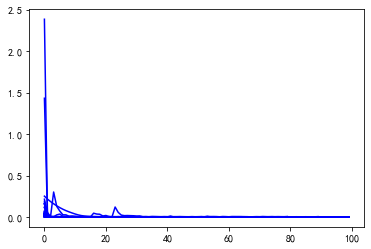

In [25]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=100)

In [26]:
best_params = study.best_params
best_params

{'batch_size': 32,
 'epochs': 100,
 'learning_rate': 0.0014176198653707659,
 'optimizer': tensorflow.python.keras.optimizer_v2.adam.Adam,
 'units': 350}

In [27]:
best_value=study.best_value
best_value

13937.98

In [35]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
display(df)
df.to_csv('350_LSTM_q=0.999_100次tail_无Dropout层的超参数确定实验结果.csv')

,number,value,params_batch_size,params_epochs,params_learning_rate,params_optimizer,params_units,state
0,0,34790.86,8,60,0.173350,<class 'tensorflow.python.keras.optimizer_v2.a...,335,COMPLETE
1,1,14692.84,64,80,0.007490,<class 'tensorflow.python.keras.optimizer_v2.a...,370,COMPLETE
2,2,17243.68,64,50,0.012425,<class 'tensorflow.python.keras.optimizer_v2.a...,350,COMPLETE
3,3,15203.82,128,60,0.022501,<class 'tensorflow.python.keras.optimizer_v2.a...,260,COMPLETE
4,4,41131.56,16,50,0.128361,<class 'tensorflow.python.keras.optimizer_v2.a...,480,COMPLETE
...,...,...,...,...,...,...,...,...
95,95,31755.88,32,100,0.074490,<class 'tensorflow.python.keras.optimizer_v2.a...,275,COMPLETE
96,96,14332.98,64,80,0.001142,<class 'tensorflow.python.keras.optimizer_v2.a...,215,COMPLETE
97,97,14834.75,64,80,0.001173,<class 'tensorflow.python.keras.optimizer_v2.a...,210,COMPLETE
98,98,15456.81,64,70,0.002136,<class 'tensorflow.python.keras.optimizer_v2.a...,195,COMPLETE


D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



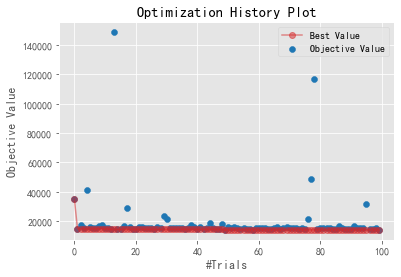

In [37]:
plot_optimization_history(study);